In [1]:
###Hide
import numpy as np
import pandas as pd
import scipy as sp
from sklearn import preprocessing
from sklearn.cross_validation import KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.ensemble import AdaBoostClassifier as AdaBoost
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn import grid_search
from sklearn.decomposition import PCA
from sklearn import feature_selection as fs
from sklearn.externals import joblib
import pickle
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# Step 3: Tuning to Maximize Model Performance

#### Step 3.1: Get Performance Metric

In [2]:
# Load the performance metric
performance_metric = pd.read_csv('datasets/performance_metric.csv', delimiter=',')

print "Our Performance Metric is to get a better score than the following:"
performance_metric

Our Performance Metric is to get a better score than the following:


,KNN,LDA,QDA,RF,SVC,Tree,Unweighted Logistic,Weighted Logistic
0,0.905711,0.906115,0.847791,0.791891,0.760776,0.896013,0.908675,0.648303
1,0.990794,0.990943,0.911210,0.843207,0.794655,0.974759,0.997327,0.657313
2,0.074020,0.076923,0.227866,0.290276,0.429608,0.126270,0.042090,0.560232


#### Step 3.2: Select Top Performing Models

Pick two of the top performing models whos accuracy score is high in both classes. From the metric table we can see that Weighted Logistic, SVC, and Random Forest performs the best. Let us pick Weighted Logistic and Random Forest, since they are easier to work with during tuning.  Now lets work towards tuning them to get better results.

#### Step 3.3: Tune Models

In this step we will work with the selected models from the previous step and tune the various parameters for the models to get the best possible accuracy scores.

In [3]:
# Load the clean data
ncds_data_no_indicators = pd.read_csv('datasets/ncds_data_no_indicators.csv', delimiter=',', low_memory=False)

In [4]:
# Function for computing the accuracy a given model on the entire test set,
# the accuracy on class 0 in the test set
# and the accuracy on class 1
score = lambda model, x_test, y_test: pd.Series([model.score(x_test, y_test), 
                                                 model.score(x_test[y_test==0], y_test[y_test==0]),
                                                 model.score(x_test[y_test==1], y_test[y_test==1])],
                                                index=['overall accuracy', 'accuracy on class 0', 'accuracy on class 1'])


In [5]:
# Best features
def get_best_feature(num_of_features,df,x_train, y_train):
    features = fs.SelectKBest(fs.f_regression, k=num_of_features) #k is number of features.
    features.fit(x_train, y_train)

    selected_features = features.get_support()
    selected_features_columns =  df.columns[selected_features].values
    return selected_features_columns


#### Weighted Logistic Regression Model Tuning

Tuning params with various number of predictors:


//anaconda/envs/py27/lib/python2.7/site-packages/pandas/indexes/base.py:1275: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1803 but corresponding boolean dimension is 1802
  result = getitem(key)


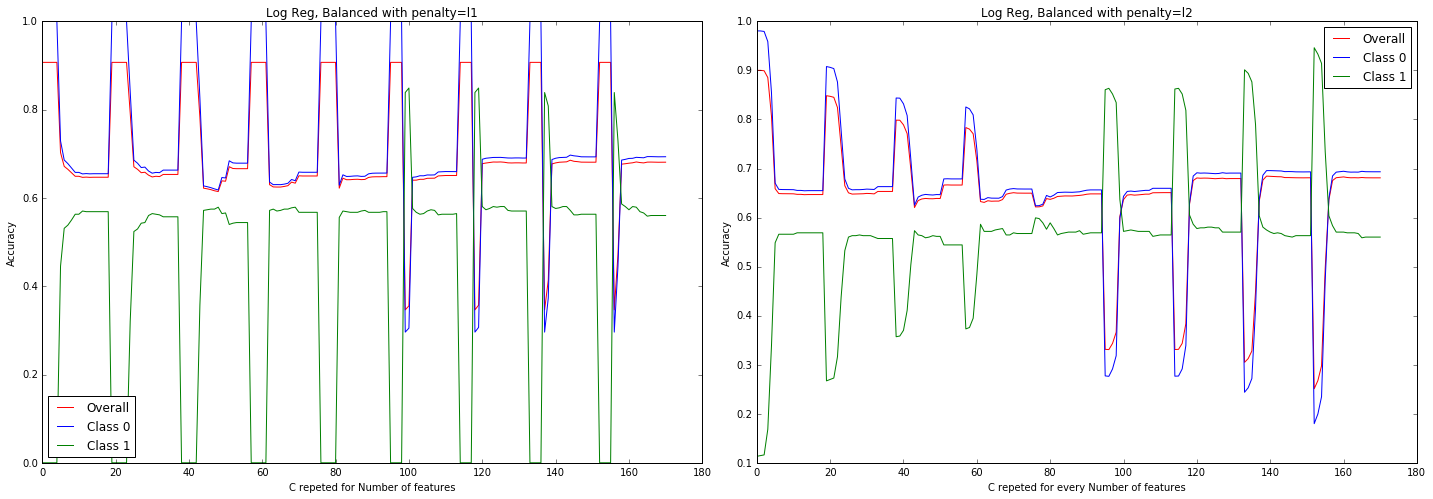

In [6]:
### Logistic Model Tuning

def tune_logistic_reg_model():
    c_list = [0.00000001,0.0000001,0.000001,0.00001,0.0001, 0.001,0.01,0.015,0.02,0.03,0.04,0.08,0.1,1,10,100,10000,100000,1000000]
    l1_overall = []
    l1_class_0 = []
    l1_class_1 = []
    l2_overall = []
    l2_class_0 = []
    l2_class_1 = []
    no_of_features = [10,15,20,25,30,35,40,45,50]
    x_index =[]
    count = 0
    x_l1_df = pd.DataFrame(columns=('x_index','Model', 'C', 'NOF', 'class0', 'class1','overall'))
    x_l2_df = pd.DataFrame(columns=('x_index','Model', 'C', 'NOF', 'class0', 'class1','overall'))
    
    for nof in no_of_features:
        # Split data for all features
        x = ncds_data_no_indicators.values[:, :-1]
        y = ncds_data_no_indicators.values[:, -1]
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)
    
    
        # Get best features
        selected_features_columns = get_best_feature(nof,ncds_data_no_indicators,x_train, y_train)

        # Split data for selected features only
        x = ncds_data_no_indicators[selected_features_columns].values[:,:]
        y = ncds_data_no_indicators.values[:, -1]

        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)

        for c in c_list:
            x_index.append(count)
            
            logistic = LogisticRegression(class_weight='balanced',C=c,penalty='l1')
            logistic.fit(x_train, y_train)
            logistic_scores = score(logistic, x_test, y_test)
            #print logistic_scores
            l1_overall.append(logistic_scores['overall accuracy'])
            l1_class_0.append(logistic_scores['accuracy on class 0'])
            l1_class_1.append(logistic_scores['accuracy on class 1'])
            
            x_l1_df.loc[count] = {'x_index':count,'Model':'Logistic l1', 'C':c, 'NOF':nof , 'class0':logistic_scores['accuracy on class 0'], 'class1':logistic_scores['accuracy on class 1'],'overall':logistic_scores['overall accuracy']}

            logistic = LogisticRegression(class_weight='balanced',C=c,penalty='l2')
            logistic.fit(x_train, y_train)
            logistic_scores = score(logistic, x_test, y_test)
            #print logistic_scores
            l2_overall.append(logistic_scores['overall accuracy'])
            l2_class_0.append(logistic_scores['accuracy on class 0'])
            l2_class_1.append(logistic_scores['accuracy on class 1'])
            
            
            
            x_l2_df.loc[count] = {'x_index':count,'Model':'Logistic l2', 'C':c, 'NOF':nof , 'class0':logistic_scores['accuracy on class 0'], 'class1':logistic_scores['accuracy on class 1'],'overall':logistic_scores['overall accuracy']}
            count = count +1

    # Plot the results
    fig, ax = plt.subplots(1, 2, figsize=(20, 7))
    ax[0].plot(x_index,l1_overall,color='r',label='Overall')
    ax[0].plot(x_index,l1_class_0,color='b',label='Class 0')
    ax[0].plot(x_index,l1_class_1,color='g',label='Class 1')
    ax[0].set_title("Log Reg, Balanced with penalty=l1")
    ax[0].set_xlabel('C repeted for Number of features')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend(loc = 'best')

    ax[1].plot(x_index,l2_overall,color='r',label='Overall')
    ax[1].plot(x_index,l2_class_0,color='b',label='Class 0')
    ax[1].plot(x_index,l2_class_1,color='g',label='Class 1')
    ax[1].set_title("Log Reg, Balanced with penalty=l2")
    ax[1].set_xlabel('C repeted for every Number of features')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend(loc = 'best')

    plt.tight_layout()
    plt.show()
    
    return x_l1_df , x_l2_df


# Tune without standarization
print "Tuning params with various number of predictors:"
tune_params_l1 , tune_params_l2 = tune_logistic_reg_model()

In [7]:
# Logistic with l1 penalty
tune_params_l1['sum'] = tune_params_l1['class0']*100 + tune_params_l1['class1']*100
tune_params_l1_sort = tune_params_l1.sort_values(['sum'], ascending=[False]).head(7)
tune_params_l1_sort.head(7)

,x_index,Model,C,NOF,class0,class1,overall,sum
143,143.0,Logistic l1,0.04,45.0,0.692205,0.580552,0.681843,127.275642
125,125.0,Logistic l1,0.08,40.0,0.691908,0.580552,0.681573,127.245947
123,123.0,Logistic l1,0.03,40.0,0.691759,0.580552,0.681439,127.231099
142,142.0,Logistic l1,0.03,45.0,0.691759,0.580552,0.681439,127.231099
158,158.0,Logistic l1,0.01,50.0,0.685820,0.586357,0.676589,127.217738
126,126.0,Logistic l1,0.10,40.0,0.691166,0.580552,0.680900,127.171708
162,162.0,Logistic l1,0.04,50.0,0.692056,0.579100,0.681573,127.115657


In [8]:
# Logistic with l2 penalty
tune_params_l2['sum'] = tune_params_l1['class0']*100 + tune_params_l1['class1']*100
tune_params_l2_sort = tune_params_l2.sort_values(['sum'], ascending=[False]).head(7)
tune_params_l2_sort.head(7)

,x_index,Model,C,NOF,class0,class1,overall,sum
143,143.0,Logistic l2,0.04,45.0,0.695026,0.567489,0.683190,127.275642
125,125.0,Logistic l2,0.08,40.0,0.689532,0.579100,0.679283,127.245947
123,123.0,Logistic l2,0.03,40.0,0.690572,0.580552,0.680361,127.231099
142,142.0,Logistic l2,0.03,45.0,0.695026,0.568940,0.683324,127.231099
158,158.0,Logistic l2,0.01,50.0,0.692650,0.570392,0.681304,127.217738
126,126.0,Logistic l2,0.10,40.0,0.689978,0.579100,0.679688,127.171708
162,162.0,Logistic l2,0.04,50.0,0.692650,0.568940,0.681169,127.115657


#### Random Forest Model Tuning

##### Tuning parameters for random forests
There are some important parameters for random forest that help in fine-tuning the results of the random forest models. Some of the tuning parameters considers for tuning were:
- Node size: In random forest since the forest are allowed to grow without pruning, the trees can have very few observations in the leaf nodes. In order to reduce the bias as much as possible we can control the node size by setting the 'min_samples_leaf' parameter in the random forest classifier
- Number of trees: The number of trees is usually set to large number like a few hundrudes. The parameter to set to control number of trees is 'n_estimators'. The ideal value for the number of trees will depend on the number of observations and predictors in our dataset.
- Number of predictors sampled: This parameter is important in determining how the tree grows independently and not being biased to just one or a few predictors. The parameter is set by using the 'max_features' argument.
- Maximum depth: This argument determines the maximum depth of the tree. This argument controls if we want to expand the tree down so that we have all our leaves as pure nodes.
- OOB score: The OOB score is set to True or False. It determines whether to use out-of-bag samples to estimate the generalization accuracy or not

In [9]:
# Split data for all features
x = ncds_data_no_indicators.values[:, :-1]
y = ncds_data_no_indicators.values[:, -1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)

# Random Forest
tune_params_rf = pd.DataFrame(columns=('x_index','Model', 'class0', 'class1','overall'))
rf_models =[]

rf = RandomForest(n_estimators=600,class_weight='balanced',oob_score=True,max_depth=4,criterion='gini')
rf.fit(x_train, y_train)
rf_scores = score(rf, x_test, y_test)
print "RF 1: " , "Accuracy Class 1:" , rf_scores['accuracy on class 1'] , " Class 0:" , rf_scores['accuracy on class 0']
tune_params_rf.loc[0] = {'x_index':1,'Model':'Random Forest 1', 'class0':rf_scores['accuracy on class 0'], 'class1':rf_scores['accuracy on class 1'],'overall':rf_scores['overall accuracy']}
rf_models.append(rf)

rf = RandomForest(n_estimators=600,class_weight='balanced',oob_score=True,max_depth=4,criterion='gini',min_samples_leaf=150)
rf.fit(x_train, y_train)
rf_scores = score(rf, x_test, y_test)
print "RF 2: " , "Accuracy Class 1:" , rf_scores['accuracy on class 1'] , " Class 0:" , rf_scores['accuracy on class 0']
tune_params_rf.loc[1] = {'x_index':2,'Model':'Random Forest 2', 'class0':rf_scores['accuracy on class 0'], 'class1':rf_scores['accuracy on class 1'],'overall':rf_scores['overall accuracy']}
rf_models.append(rf)

rf = RandomForest(n_estimators=600,class_weight='balanced',oob_score=True,max_depth=5,criterion='gini',min_samples_leaf=150)
rf.fit(x_train, y_train)
rf_scores = score(rf, x_test, y_test)
print "RF 3: " , "Accuracy Class 1:" , rf_scores['accuracy on class 1'] , " Class 0:" , rf_scores['accuracy on class 0']
tune_params_rf.loc[2] = {'x_index':3,'Model':'Random Forest 3', 'class0':rf_scores['accuracy on class 0'], 'class1':rf_scores['accuracy on class 1'],'overall':rf_scores['overall accuracy']}
rf_models.append(rf)

rf = RandomForest(n_estimators=600,class_weight='balanced',oob_score=True,max_depth=5,criterion='gini',min_samples_leaf=200)
rf.fit(x_train, y_train)
rf_scores = score(rf, x_test, y_test)
print "RF 4: " , "Accuracy Class 1:" , rf_scores['accuracy on class 1'] , " Class 0:" , rf_scores['accuracy on class 0']
tune_params_rf.loc[3] = {'x_index':4,'Model':'Random Forest 4', 'class0':rf_scores['accuracy on class 0'], 'class1':rf_scores['accuracy on class 1'],'overall':rf_scores['overall accuracy']}
rf_models.append(rf)

rf = RandomForest(n_estimators=600,class_weight='balanced',oob_score=True,max_depth=4,criterion='gini',min_samples_leaf=300)
rf.fit(x_train, y_train)
rf_scores = score(rf, x_test, y_test)
print "RF 5: " , "Accuracy Class 1:" , rf_scores['accuracy on class 1'] , " Class 0:" , rf_scores['accuracy on class 0']
tune_params_rf.loc[4] = {'x_index':5,'Model':'Random Forest 5', 'class0':rf_scores['accuracy on class 0'], 'class1':rf_scores['accuracy on class 1'],'overall':rf_scores['overall accuracy']}
rf_models.append(rf)

rf = RandomForest(n_estimators=600,class_weight='balanced',oob_score=True,max_depth=4,criterion='gini',min_samples_leaf=400)
rf.fit(x_train, y_train)
rf_scores = score(rf, x_test, y_test)
print "RF 6: " , "Accuracy Class 1:" , rf_scores['accuracy on class 1'] , " Class 0:" , rf_scores['accuracy on class 0']
tune_params_rf.loc[5] = {'x_index':6,'Model':'Random Forest 6', 'class0':rf_scores['accuracy on class 0'], 'class1':rf_scores['accuracy on class 1'],'overall':rf_scores['overall accuracy']}
rf_models.append(rf)

rf = RandomForest(n_estimators=600,class_weight='balanced',oob_score=True,max_depth=4,criterion='gini',min_samples_leaf=500)
rf.fit(x_train, y_train)
rf_scores = score(rf, x_test, y_test)
print "RF 7: " , "Accuracy Class 1:" , rf_scores['accuracy on class 1'] , " Class 0:" , rf_scores['accuracy on class 0']
tune_params_rf.loc[6] = {'x_index':7,'Model':'Random Forest 7', 'class0':rf_scores['accuracy on class 0'], 'class1':rf_scores['accuracy on class 1'],'overall':rf_scores['overall accuracy']}
rf_models.append(rf)


RF 1:  Accuracy Class 1: 0.641509433962  Class 0: 0.940608760208
RF 2:  Accuracy Class 1: 0.66618287373  Class 0: 0.796733481811
RF 3:  Accuracy Class 1: 0.658925979681  Class 0: 0.803266518189
RF 4:  Accuracy Class 1: 0.683599419448  Class 0: 0.754565701559
RF 5:  Accuracy Class 1: 0.721335268505  Class 0: 0.684187082405
RF 6:  Accuracy Class 1: 0.724238026125  Class 0: 0.646028210839
RF 7:  Accuracy Class 1: 0.724238026125  Class 0: 0.62004454343


In [10]:
# Random forest
tune_params_rf['sum'] = tune_params_rf['class0']*100 + tune_params_rf['class1']*100
tune_params_rf.head(7)

,x_index,Model,class0,class1,overall,sum
0,1.0,Random Forest 1,0.940609,0.641509,0.912850,158.211819
1,2.0,Random Forest 2,0.796733,0.666183,0.784617,146.291636
2,3.0,Random Forest 3,0.803267,0.658926,0.789871,146.219250
3,4.0,Random Forest 4,0.754566,0.683599,0.747980,143.816512
4,5.0,Random Forest 5,0.684187,0.721335,0.687635,140.552235
5,6.0,Random Forest 6,0.646028,0.724238,0.653287,137.026624
6,7.0,Random Forest 7,0.620045,0.724238,0.629714,134.428257


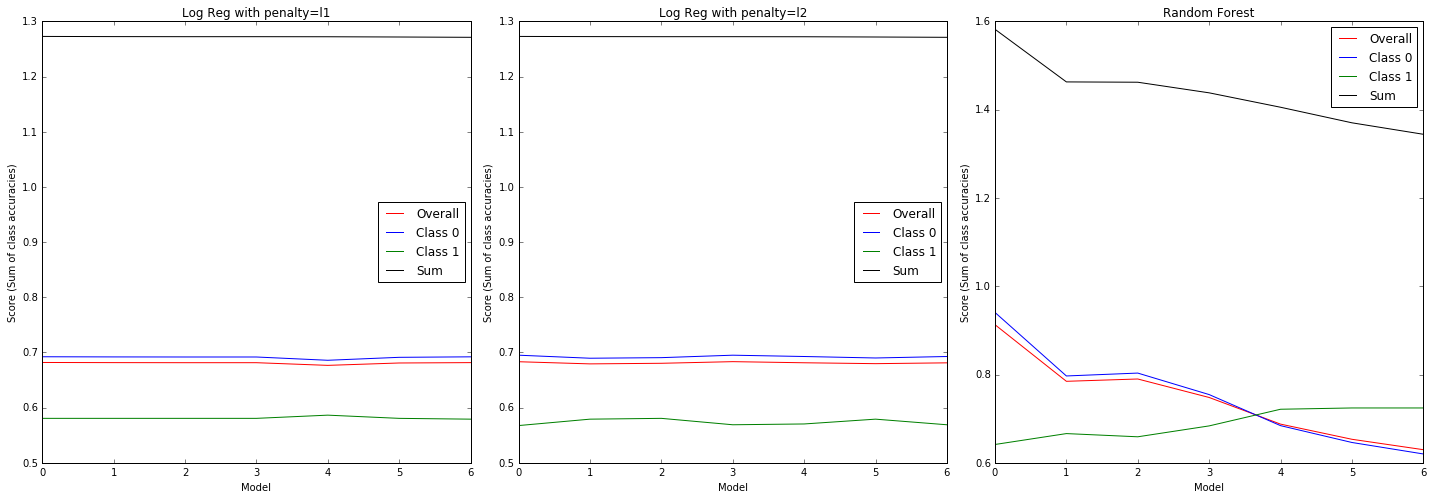

In [11]:
# Plot all the top models
fig, ax = plt.subplots(1, 3, figsize=(20, 7))
ax[0].plot(range(7),tune_params_l1_sort['overall'].values,color='r',label='Overall')
ax[0].plot(range(7),tune_params_l1_sort['class0'].values,color='b',label='Class 0')
ax[0].plot(range(7),tune_params_l1_sort['class1'].values,color='g',label='Class 1')
ax[0].plot(range(7),(tune_params_l1_sort['sum']/100).values,color='k',label='Sum')
ax[0].set_title("Log Reg with penalty=l1")
ax[0].set_xlabel('Model')
ax[0].set_ylabel('Score (Sum of class accuracies)')
ax[0].legend(loc = 'best')

ax[1].plot(range(7),tune_params_l2_sort['overall'].values,color='r',label='Overall')
ax[1].plot(range(7),tune_params_l2_sort['class0'].values,color='b',label='Class 0')
ax[1].plot(range(7),tune_params_l2_sort['class1'].values,color='g',label='Class 1')
ax[1].plot(range(7),(tune_params_l2_sort['sum']/100).values,color='k',label='Sum')
ax[1].set_title("Log Reg with penalty=l2")
ax[1].set_xlabel('Model')
ax[1].set_ylabel('Score (Sum of class accuracies)')
ax[1].legend(loc = 'best')

ax[2].plot(range(7),tune_params_rf['overall'].values,color='r',label='Overall')
ax[2].plot(range(7),tune_params_rf['class0'].values,color='b',label='Class 0')
ax[2].plot(range(7),tune_params_rf['class1'].values,color='g',label='Class 1')
ax[2].plot(range(7),(tune_params_rf['sum']/100).values,color='k',label='Sum')
ax[2].set_title("Random Forest")
ax[2].set_xlabel('Model')
ax[2].set_ylabel('Score (Sum of class accuracies)')
ax[2].legend(loc = 'best')

plt.tight_layout()
plt.show()

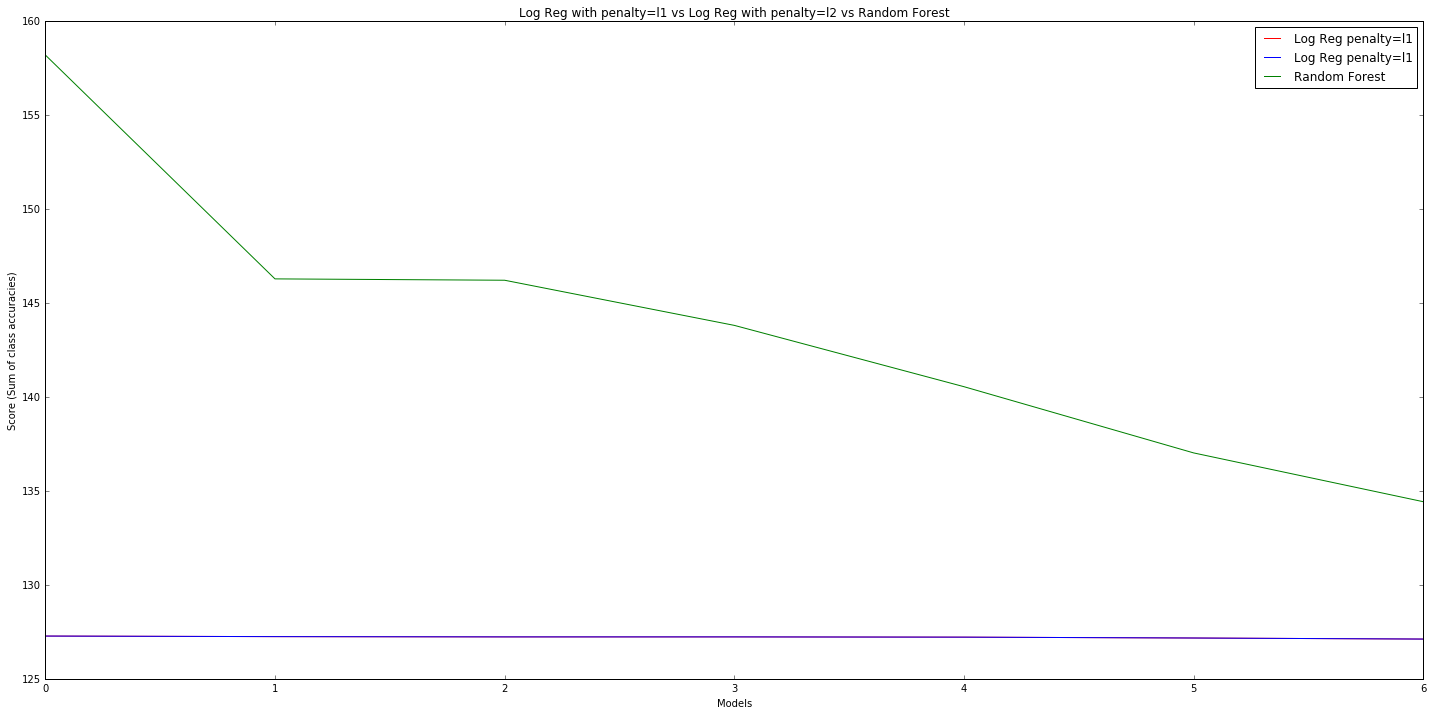

In [12]:
# Plot all the top models
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(range(7),tune_params_l1_sort['sum'].values,color='r',label='Log Reg penalty=l1')
ax.plot(range(7),tune_params_l2_sort['sum'].values,color='b',label='Log Reg penalty=l1')
ax.plot(range(7),tune_params_rf['sum'].values,color='g',label='Random Forest')
ax.set_title("Log Reg with penalty=l1 vs Log Reg with penalty=l2 vs Random Forest")
ax.set_xlabel('Models')
ax.set_ylabel('Score (Sum of class accuracies)')
ax.legend(loc = 'best')

plt.tight_layout()
plt.show()

##### Majority classifier for random forests
We can combine the various random forest classifiers and build a model to predict using the majority vote from trees in the ensemble. Let su try that to see if we can get an improved accuracy score 

In [13]:
# Prepare data for majority classifier
x = ncds_data_no_indicators.values[:, :-1]
y = ncds_data_no_indicators.values[:, -1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)

def majority_classifier(x_test,models):
    # Accuracy of majority classifier
    n_test = x_test.shape[0]
    y_pred_tot = np.zeros(n_test)
    no_of_models = len(models)

    # Iterate over random forest models
    for i in range(no_of_models):
        # For each model, predict on the entire testing set
        y_pred_tot += models[i].predict(x_test)

    # Take the majority label for each test point    
    y_pred_maj = np.zeros(n_test)
    y_pred_maj[y_pred_tot > no_of_models / 2.] = 1
    
    return y_pred_maj


# All the data
print "Accuracy Score for all data:"
y_pred_maj = majority_classifier(x,rf_models)
accuracy = metrics.accuracy_score(y,y_pred_maj)
print "Overall accuracy: ", accuracy

y_pred_maj = majority_classifier(x[y==1],rf_models)
accuracy = metrics.accuracy_score(y[y==1],y_pred_maj)
print "Accuracy Class 1: ", accuracy

y_pred_maj = majority_classifier(x[y==0],rf_models)
accuracy = metrics.accuracy_score(y[y==0],y_pred_maj)
print "Accuracy Class 0: ", accuracy

print ""
print "Accuracy Score for test data:"
y_pred_maj = majority_classifier(x_test,rf_models)
accuracy = metrics.accuracy_score(y_test,y_pred_maj)
print "Overall accuracy: ", accuracy

y_pred_maj = majority_classifier(x_test[y_test==1],rf_models)
accuracy = metrics.accuracy_score(y_test[y_test==1],y_pred_maj)
print "Accuracy Class 1: ", accuracy

y_pred_maj = majority_classifier(x_test[y_test==0],rf_models)
accuracy = metrics.accuracy_score(y_test[y_test==0],y_pred_maj)
print "Accuracy Class 0: ", accuracy

Accuracy Score for all data:
Overall accuracy:  0.751320185365
Accuracy Class 1:  0.722222222222
Accuracy Class 0:  0.754273504274

Accuracy Score for test data:
Overall accuracy:  0.745150862069
Accuracy Class 1:  0.686502177068
Accuracy Class 0:  0.751150705271


#### Step 3.4: Perform Cross Validation

In this step we will pick the top performing models and perform k fold cross validation. This steps ensures that we have generalized results independent of datasets.

In [14]:
# Prepare data for model evaluation / Validation
x = ncds_data_no_indicators.values[:, :-1]
y = ncds_data_no_indicators.values[:, -1]

def cross_validate_model(model,x,y,k):
    total_rows = x.shape[0]
    # Create a k-fold split using sklearn
    kf = KFold(total_rows, n_folds=k)
    k_index = 0
    model_scores = []
    for train_index, test_index in kf:
        k_index = k_index +1
        x_train = x[train_index,:]
        y_train = y[train_index]
        x_test = x[test_index,:]
        y_test = y[test_index]
        
        # Fit model
        model.fit(x_train, y_train)
        model_score = score(model, x_test, y_test)
        model_scores.append(model_score)
    
    scores_df = pd.concat(model_scores, axis=1)
    return scores_df.mean(axis=1)

In [15]:
# Perform k fold cross validations on all the top models
cv_rf = pd.DataFrame(columns=('x_index','Model', 'class0', 'class1','overall'))
for i in range(len(rf_models)):
    model_scores = cross_validate_model(rf_models[i],x,y,5)
    cv_rf.loc[i] = {'x_index':i+1,'Model':'Random Forest '+str(i+1), 'class0':model_scores.iloc[1], 'class1':model_scores.iloc[2],'overall':model_scores.iloc[0]}
    

In [16]:
print "Scores from model validation of Random Forest:"
cv_rf['sum'] = cv_rf['class0']*100 + cv_rf['class1']*100
cv_rf.head(7)

Scores from model validation of Random Forest:


,x_index,Model,class0,class1,overall,sum
0,1.0,Random Forest 1,0.844977,0.642594,0.833129,148.757069
1,2.0,Random Forest 2,0.700448,0.683092,0.707910,138.354022
2,3.0,Random Forest 3,0.738435,0.658245,0.739483,139.667999
3,4.0,Random Forest 4,0.688237,0.659417,0.695301,134.765361
4,5.0,Random Forest 5,0.582880,0.683663,0.603217,126.654299
5,6.0,Random Forest 6,0.554201,0.690207,0.577729,124.440760
6,7.0,Random Forest 7,0.533300,0.686869,0.558601,122.016918


In [17]:
print "Scores from model tuning of Random Forest:"
tune_params_rf.head(7)

Scores from model tuning of Random Forest:


,x_index,Model,class0,class1,overall,sum
0,1.0,Random Forest 1,0.940609,0.641509,0.912850,158.211819
1,2.0,Random Forest 2,0.796733,0.666183,0.784617,146.291636
2,3.0,Random Forest 3,0.803267,0.658926,0.789871,146.219250
3,4.0,Random Forest 4,0.754566,0.683599,0.747980,143.816512
4,5.0,Random Forest 5,0.684187,0.721335,0.687635,140.552235
5,6.0,Random Forest 6,0.646028,0.724238,0.653287,137.026624
6,7.0,Random Forest 7,0.620045,0.724238,0.629714,134.428257


#### Step 3.5: Select Top Performing Models

From the accuracy scores from the previous steps we can pick three models as our final models
- A model that performs well overall on both class 0 and class 1 predictions
- A model that performs well on class 0 predictions
- A model that performs well on class 1 predictions

In [18]:
# Select top performing models

# Prepare data for final model building
x = ncds_data_no_indicators.values[:, :-1]
y = ncds_data_no_indicators.values[:, -1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)

# Best overall performance
best_overall = rf_models[0]
best_overall.fit(x_train, y_train)
# save the model to disk
pickle.dump(best_overall, open('datasets/best_overall.pkl', 'wb'))

# Best class 0 performance
best_class0 = rf_models[0]
best_class0.fit(x_train, y_train)
# save the model to disk
pickle.dump(best_class0, open('datasets/best_class0.pkl', 'wb'))

# Best class 1 performance
best_class1 = rf_models[5]
best_class1.fit(x_train, y_train)
# save the model to disk
pickle.dump(best_class1, open('datasets/best_class1.pkl', 'wb'))
